## Resources

Masking a raster using a shapefile
<br>https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
<br>https://github.com/mapbox/rasterio/tree/master/tests/data

In [1]:
raster_path = 'NYC/raster/nlcd2016_ny.tif'

In [2]:
import fiona
import rasterio
import rasterio.mask
import rasterio.plot
import geopandas as gpd
import glob
import os

from shapely.geometry import MultiPolygon, Polygon, box
from matplotlib import pyplot

%matplotlib inline

## Masking a raster using a shapefile

Utilizing data and instructions from rasterio documentation

In [3]:
with fiona.open("General/box.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [4]:
with rasterio.open("General/RGB.byte.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [5]:
# Save as .tif file

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("General/RGB.byte.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [6]:
# Save as .bil file

out_meta.update({"driver": 'EHdr',
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("General/RGB.byte.masked.bil", "w", **out_meta) as dest:
    dest.write(out_image)

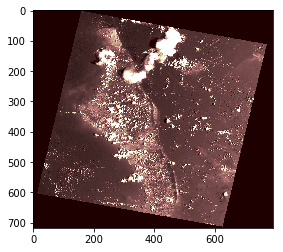

In [7]:
# Image / Plot of original raster

src = rasterio.open("General/RGB.byte.tif")
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

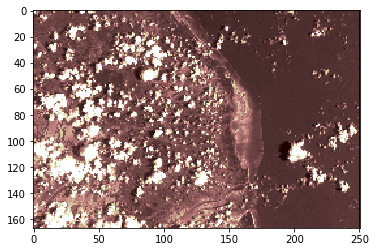

In [8]:
# Image / Plot of masked raster

src = rasterio.open("General/RGB.byte.masked.tif")
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

In [9]:
for filename in glob.glob("./General/RGB.byte.masked*"):
    print(filename)
    os.remove(filename)

./General/RGB.byte.masked.hdr
./General/RGB.byte.masked.tif
./General/RGB.byte.masked.bil.aux.xml
./General/RGB.byte.masked.prj
./General/RGB.byte.masked.bil


## Masking a raster using a shapefile

Utilizing public NYC data

In [10]:
towns = gpd.read_file("NYC/cities_towns/Cities_Towns.shp")
print(towns.crs)

# Convert crs to the same crs as raster
towns = towns.to_crs({'init': 'epsg:5070'})

# Put the geometry of only New York in a list
shapes = [town.__geo_interface__ for town in towns[towns["NAME"]=="New York"]["geometry"]]

{u'init': u'epsg:26918'}


In [11]:
with rasterio.open(raster_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [12]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("NYC/raster/nyc250.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

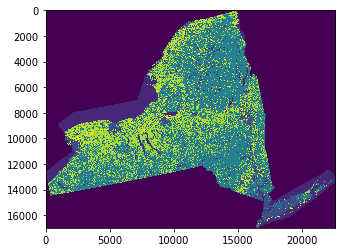

In [13]:
# Image / Plot of original raster

src = rasterio.open(raster_path)
pyplot.imshow(src.read(1))
pyplot.show()

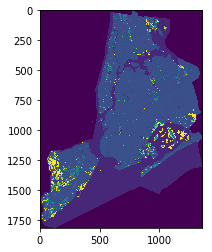

In [14]:
# Image / Plot of masked raster

src = rasterio.open("NYC/raster/nyc250.masked.tif")
pyplot.imshow(src.read(1))
pyplot.show()

In [15]:
for filename in glob.glob("./NYC/raster/nyc250.masked*"):
    print(filename)
    os.remove(filename)

./NYC/raster/nyc250.masked.tif


## Transform Raster to vector Polygon 'box'

Use the bounds of raster to create vector Polygon 'box'

In [16]:
def change_shapely_crs(shpl,source_crs,final_crs):
    gpd_box = gpd.GeoDataFrame(index=[0], crs=source_crs, geometry=[shpl])  
    gpd_box = gpd_box.to_crs(final_crs)
    return Polygon(gpd_box["geometry"][0])

def raster_to_box(path):
    with rasterio.open(path) as dataset:
        minx, miny, maxx, maxy = dataset.bounds
        box_crs = dataset.crs
    box_frame = box(minx, miny, maxx, maxy)
    box_frame = change_shapely_crs(box_frame,box_crs,{'init': 'epsg:4326', 'no_defs': True})
    return box_frame

In [17]:
box_frame = raster_to_box(raster_path)

In [18]:
print(box_frame)

POLYGON ((-72.11422610057707 40.08640131401854, -70.5164599533467 44.4928080940551, -78.93964930923465 45.84777411105858, -80.03567435057458 41.34804050541371, -72.11422610057707 40.08640131401854))


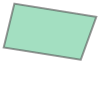

In [19]:
box_frame

In [20]:
# GeoJSON format
# Useful for MongoDB and programming languages other than Python

box_frame.__geo_interface__

{'coordinates': (((-72.11422610057707, 40.086401314018545),
   (-70.5164599533467, 44.4928080940551),
   (-78.93964930923465, 45.847774111058584),
   (-80.03567435057458, 41.348040505413714),
   (-72.11422610057707, 40.086401314018545)),),
 'type': 'Polygon'}